<span style="color:darkblue"><font size="5"> DeCockHousePrice Dataset: Salerice Level Classification </font></span> 

In [167]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import numpy as np
np.random.seed(10)
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

In [168]:
df=pd.read_csv('data/train.csv')

# Data cleaning

In [169]:
cg_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
dc_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']
ot_cols = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities']
for col in dc_cols:
    df[col].replace(np.nan, 0, inplace=True)

for col in cg_cols:
    df[col].replace(np.nan, 'None', inplace=True)

for col in ot_cols:
    df[col].replace(np.nan, df[col].mode()[0], inplace=True)
    
# Filling MSZoning according to MSSubClass
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

# Filling LotFrontage according to Neighborhood

df['LotFrontage']=df.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [170]:
df.drop('Id',axis=1,inplace=True)

#binning with rare values
col_rare = ['Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType']

for col in col_rare:
    mask = df[col].isin(
        df[col].value_counts()[df[col].value_counts() < 10].index)
    df[col][mask] = 'Other'

In [172]:
# Features which numerical on data but should be treated as category.
df['MSSubClass'] = df['MSSubClass'].astype(str)

# cyclical feature transformation
from math import pi
df['MoSold']=2*pi*df['MoSold']/df['MoSold'].max()
df["cos_MoSold"] = np.cos(df["MoSold"])
df["sin_MoSold"] = np.sin(df["MoSold"])

In [174]:
neigh_map={'MeadowV': 1,'IDOTRR': 1,
    'BrDale': 1, 'BrkSide': 2,
    'OldTown': 2, 'Edwards': 2,
    'Sawyer': 3,    'Blueste': 3,
    'SWISU': 3,    'NPkVill': 3,
    'NAmes': 3,    'Mitchel': 4,
    'SawyerW': 5,    'NWAmes': 5,
    'Gilbert': 5,    'Blmngtn': 5,
    'CollgCr': 5,    'ClearCr': 6,
    'Crawfor': 6,    'Veenker': 7,
    'Somerst': 7,    'Timber': 8,
    'StoneBr': 9,    'NridgHt': 10,
    'NoRidge': 10}
    
df['Neighborhood'] = df['Neighborhood'].map(neigh_map).astype('int')

ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['ExterCond'] = df['ExterCond'].map(ext_map).astype('int')
df['ExterQual'] = df['ExterQual'].map(ext_map).astype('int')

bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['BsmtQual'] = df['BsmtQual'].map(bsm_map).astype('int')
df['BsmtCond'] = df['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {'None': 0, 'Unf': 1,'LwQ': 2,'Rec': 3, 'BLQ': 4, 'ALQ': 5,'GLQ': 6}

df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmf_map).astype('int')
df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['HeatingQC'] = df['HeatingQC'].map(heat_map).astype('int')
df['KitchenQual'] = df['KitchenQual'].map(heat_map).astype('int')
df['FireplaceQu'] = df['FireplaceQu'].map(bsm_map).astype('int')
df['GarageCond'] = df['GarageCond'].map(bsm_map).astype('int')
df['GarageQual'] = df['GarageQual'].map(bsm_map).astype('int')

In [175]:
# Getting dummy variables for nominal categorical features
df = pd.get_dummies(data=df)

In [622]:
#Categorize SalePrice into binary variable
df["SalePrice"].median()
df.loc[df['SalePrice'] <= 163000, 'SalePrice'] = 0
df.loc[df['SalePrice'] > 163000, 'SalePrice'] = 1

0.0

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 215 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(6), int64(44), uint8(165)
memory usage: 805.7 KB


In [179]:
df.head()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_COD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,5,7,5,2003,2003,196.0,4,3,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,7,6,8,1976,1976,0.0,3,3,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,5,7,5,2001,2002,162.0,4,3,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,6,7,5,1915,1970,0.0,3,3,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,10,8,5,2000,2000,350.0,4,3,...,0,0,0,1,0,0,0,0,1,0


# Feature Selection 
    - Based on correlation
    
    - Based on P-value

In [339]:
corr = df.corr()
corr.head()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,MiscFeature_TenC,SaleType_COD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
LotFrontage,1.000000,0.335957,0.250274,0.239546,-0.043595,0.120999,0.084550,0.195830,0.166857,-0.006124,...,0.011442,-0.004261,0.122643,-0.017725,-0.090900,-0.014946,-0.036696,-0.018572,0.013666,-0.073047
LotArea,0.335957,1.000000,0.168539,0.105806,-0.005636,0.014228,0.013788,0.103321,0.055570,0.014732,...,0.016203,-0.016019,0.020039,-0.015026,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711
Neighborhood,0.250274,0.168539,1.000000,0.684318,-0.219006,0.647928,0.506673,0.402346,0.652067,-0.062696,...,0.005388,-0.068483,0.327229,-0.032468,-0.220026,-0.090647,-0.053492,-0.024682,-0.045602,-0.150234
OverallQual,0.239546,0.105806,0.684318,1.000000,-0.091932,0.572323,0.550684,0.407252,0.726278,0.013953,...,0.017056,-0.065259,0.327412,-0.024494,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282
OverallCond,-0.043595,-0.005636,-0.219006,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.138942,0.389163,...,-0.013540,-0.028186,-0.156175,-0.054364,0.163684,-0.046367,-0.038888,-0.033444,-0.023873,0.161642


In [340]:
#Remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]

In [341]:
df = df[selected_columns]

selected_columns

selected_columns=selected_columns.tolist()

selected_columns.remove('SalePrice')

selected_columns=np.array(selected_columns)

numpy.ndarray

In [342]:
import statsmodels.regression.linear_model as sm

In [343]:
X=df.drop('SalePrice',axis=1).values
y=df.loc[:,'SalePrice'].values

In [344]:
numVars = df.shape[1]-1
for i in range(0, numVars):
    regressor_OLS = sm.OLS(y, X).fit()
    maxVar = max(regressor_OLS.pvalues).astype(float)
    if maxVar > 0.05:
        for j in range(0, numVars - i):
            if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                X = np.delete(X, j, 1)
                selected_columns = np.delete(selected_columns, j)

In [834]:
selected_columns.size

49

In [835]:
X.shape

(1460, 49)

# Data Scaling

In [697]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X = minmax.fit_transform(X)

# Logistic Regression Model Training and Evaluation

In [836]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=0)

In [837]:
#logistic regression only
lm = LogisticRegression(C=1,max_iter=1500)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
y_pred_lm = lm.predict_proba(X_test)[:, 1]
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_lm)

In [838]:
lm.score(X_train,y_train)

0.9314928425357873

In [839]:
lm.score(X_test,y_test)

0.9294605809128631

In [848]:
from sklearn.model_selection import cross_val_score
regressor_model = LogisticRegression()
regressor_model.fit(X, y,)
print(cross_val_score(regressor_model,X, y,cv=5))

[0.93835616 0.92808219 0.90068493 0.94178082 0.92465753]


In [841]:
from sklearn.metrics import f1_score, confusion_matrix
f1_score(y_test, y_pred)

0.9288702928870293

In [ ]:
regressor_model.

In [842]:
confusion_matrix(y_test, y_pred)

array([[226,  18],
       [ 16, 222]])

 <span style="color:blue"><font size="4">The model is underfitted. Next：try feature transformation </font></span>

# Feature Transformation + LogisticRegression 

In [843]:
#split the training set to ensemble feature transformation model(gradient boosted trees) 
#on a different subset of the training data than the linear regression model to avoid overfitting
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
X_train, y_train, test_size=0.5,random_state=0)

In [856]:
#transformation based on gradient boosted trees
grd = GradientBoostingClassifier(min_samples_split=2,min_samples_leaf=5,n_estimators=35)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(C=1,max_iter=1500)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [857]:
#logistic regression model training
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
# y_pred_grd_lm = grd_lm.predict_proba(
#     grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [858]:
# Performance on training set
grd_lm.score(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]),y_train_lr)

0.9734151329243353

In [873]:
# Perfomance on test set
grd_lm.score(grd_enc.transform(grd.apply(X_test)[:, :, 0]),y_test)

0.9232365145228216

In [868]:
#transformation based on gradient boosted trees
grd = GradientBoostingClassifier(min_samples_split=2,min_samples_leaf=5,n_estimators=35)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(C=0.2,max_iter=1500)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [869]:
#logistic regression model training
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

In [870]:
grd_lm.score(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]),y_train_lr)

0.9406952965235174

In [871]:
grd_lm.score(grd_enc.transform(grd.apply(X_test)[:, :, 0]),y_test)

0.9232365145228216

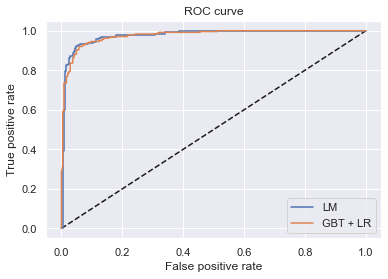

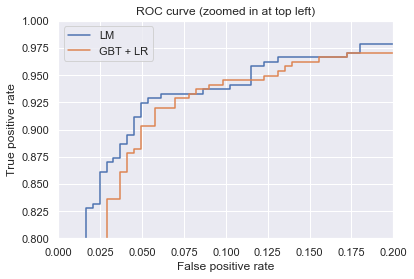

In [872]:
# Comparing new new model with previous model
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label='LM')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label='LM')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Problem:
- After tree based feature transformation is done, Model performance is obviously improved on training set, but the tradeoff is variance problem, test accuracy didn't change at all.
- Tree based feature transformation + LogisticRegression（with regularization) ≈  LogisticRegression
- Bias problem still exists
    

# solution
- Biger training set
- Collect more valuable features
- Manully creat new features from existing features
- Change feature selection strategy
- more complex model, Tree or SVM